In [2]:
import zipfile
import os


In [3]:
zip_file_path = 'Dataset Brain Tumor.zip'  # Replace with your file's name
extract_dir = 'Dataset Brain Tumor'  # Replace with the desired extraction directory


In [3]:
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [4]:
extracted_files = os.listdir(extract_dir)
print(extracted_files)

['Dataset Brain Tumor', 'vi.py']


In [5]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import vit_keras as vit
from tensorflow.keras.models import Model

# Load training data
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(
    'Dataset Brain Tumor/Dataset Brain Tumor/Training Dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

2024-10-09 02:43:09.322196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 02:43:09.570506: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 02:43:09.576374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/sqlite-autoconf-3420000/build/lib:/usr/local/cuda-12.0/lib64:/opt/pbs/lib:
202

Found 5708 images belonging to 4 classes.


In [6]:
# Data preprocessing for testing dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'Dataset Brain Tumor/Dataset Brain Tumor/Testing Dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to not shuffle so we can map predictions correctly
)


Found 1273 images belonging to 4 classes.


In [11]:
from vit_keras import vit
# Load the ViT model
vit_model = vit.vit_b32(
    image_size=224,
    pretrained=True,
    include_top=True
)

# Create a new model with ViT as the base
input_layer = Input(shape=(224, 224, 3))
vit_output = vit_model(input_layer)

# Add custom layers for classification
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(vit_output)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_layer, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-5, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# Load the best saved model after training
best_model = load_model('best_model.keras')

# Get true labels and predictions
y_true = test_generator.classes
y_pred = best_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

/nfsshare/achuthan/.local/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2024-10-09 02:48:03.503040: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /nfsshare/achuthan/.local/lib/python3.9/site-packages/cv2/../../lib64:/opt/sqlite-autoconf-3420000/build/lib:/usr/local/cuda-12.0/lib64:/opt/pbs/lib:
2024-10-09 02:48:03.506385: W tensorflow/compiler/xla/stre

Epoch 1/50
179/179 [==============================] - ETA: 0s - loss: 9.7582 - accuracy: 0.8238
Epoch 1: val_accuracy improved from -inf to 0.88452, saving model to best_model.keras
179/179 [==============================] - 348s 2s/step - loss: 9.7582 - accuracy: 0.8238 - val_loss: 8.7310 - val_accuracy: 0.8845 - lr: 1.0000e-04
Epoch 2/50
179/179 [==============================] - ETA: 0s - loss: 7.8497 - accuracy: 0.9115
Epoch 2: val_accuracy did not improve from 0.88452
179/179 [==============================] - 231s 1s/step - loss: 7.8497 - accuracy: 0.9115 - val_loss: 7.3875 - val_accuracy: 0.8507 - lr: 1.0000e-04
Epoch 3/50
179/179 [==============================] - ETA: 0s - loss: 6.3290 - accuracy: 0.9243
Epoch 3: val_accuracy did not improve from 0.88452
179/179 [==============================] - 231s 1s/step - loss: 6.3290 - accuracy: 0.9243 - val_loss: 5.8805 - val_accuracy: 0.8751 - lr: 1.0000e-04
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 5.0363 


Epoch 27: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
179/179 [==============================] - 231s 1s/step - loss: 0.0758 - accuracy: 0.9807 - val_loss: 0.0791 - val_accuracy: 0.9804 - lr: 1.0000e-04
Epoch 28/50
179/179 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9923
Epoch 28: val_accuracy improved from 0.98665 to 0.99057, saving model to best_model.keras
179/179 [==============================] - 242s 1s/step - loss: 0.0428 - accuracy: 0.9923 - val_loss: 0.0547 - val_accuracy: 0.9906 - lr: 2.0000e-05
Epoch 29/50
179/179 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9940
Epoch 29: val_accuracy improved from 0.99057 to 0.99293, saving model to best_model.keras
179/179 [==============================] - 243s 1s/step - loss: 0.0377 - accuracy: 0.9940 - val_loss: 0.0490 - val_accuracy: 0.9929 - lr: 2.0000e-05
Epoch 30/50
179/179 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9937
Epo

In [26]:
# Evaluate the model on your test data
test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

40/40 [==============================] - 18s 359ms/step - loss: 0.0341 - accuracy: 0.9961
Test Loss: 0.03409804031252861
Test Accuracy: 0.9960722923278809


In [12]:

print("True Classes (y_true):", y_true)
print("Predicted Probabilities (y_pred):", y_pred)
print("Predicted Classes (y_pred_classes):", y_pred_classes)


True Classes (y_true): [0 0 0 ... 3 3 3]
Predicted Probabilities (y_pred): [[9.9999768e-01 6.0467579e-07 1.0985768e-06 6.1795538e-07]
 [9.9999088e-01 3.7975879e-06 8.4557553e-07 4.4594308e-06]
 [9.9994797e-01 4.8594015e-05 2.0497043e-06 1.2957698e-06]
 ...
 [8.0526286e-07 1.3617951e-05 9.8305975e-07 9.9998456e-01]
 [5.2647720e-05 3.6107514e-07 4.9898340e-06 9.9994189e-01]
 [6.2735871e-06 1.3453350e-06 3.7858340e-06 9.9998856e-01]]
Predicted Classes (y_pred_classes): [0 0 0 ... 3 3 3]


In [20]:
print("True Class")
for i in range(len(y_true)):
    print(y_true[i],end = " ")

True Class
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [21]:
print("Predicted Probabilities :" )
for i in range(len(y_pred)):
    print(y_pred[i],end = "")

Predicted Probabilities :
[9.9999768e-01 6.0467579e-07 1.0985768e-06 6.1795538e-07][9.9999088e-01 3.7975879e-06 8.4557553e-07 4.4594308e-06][9.9994797e-01 4.8594015e-05 2.0497043e-06 1.2957698e-06][9.99998629e-01 7.05160687e-07 4.35562356e-07 1.08859645e-07][9.9999541e-01 3.1607769e-06 2.7970464e-07 1.1134442e-06][9.9993795e-01 5.4019616e-05 1.1778371e-06 6.8178033e-06][9.9991697e-01 6.5791508e-05 1.5320160e-05 1.7547931e-06][9.9994987e-01 7.2298017e-06 4.2525309e-05 2.6909996e-07][9.9999613e-01 1.7310591e-06 6.7436417e-07 1.3331684e-06][9.9610293e-01 3.4182100e-03 2.0370401e-04 2.7516214e-04][9.9997479e-01 2.1610094e-05 1.0357483e-06 2.5389645e-06][9.9997360e-01 2.2276068e-05 2.6074673e-07 3.7579500e-06][9.9999493e-01 1.4432991e-06 5.4904990e-07 2.9460655e-06][9.9998158e-01 4.1103217e-06 2.6040561e-07 1.4028807e-05][9.9999744e-01 1.5191241e-06 1.2114926e-07 7.7637372e-07][9.9998957e-01 2.0934458e-06 7.0109841e-08 8.1062708e-06][9.9998802e-01 9.4575826e-06 2.7631188e-07 2.2873146e-06][

In [24]:
print("Predicted Class")
for i in range(len(y_pred_classes)):
    print(y_pred_classes[i],end = " ")

Predicted Class
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [13]:
# Classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print(report)

              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       262
  meningioma       1.00      0.99      1.00       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           1.00      1273
   macro avg       1.00      1.00      1.00      1273
weighted avg       1.00      1.00      1.00      1273



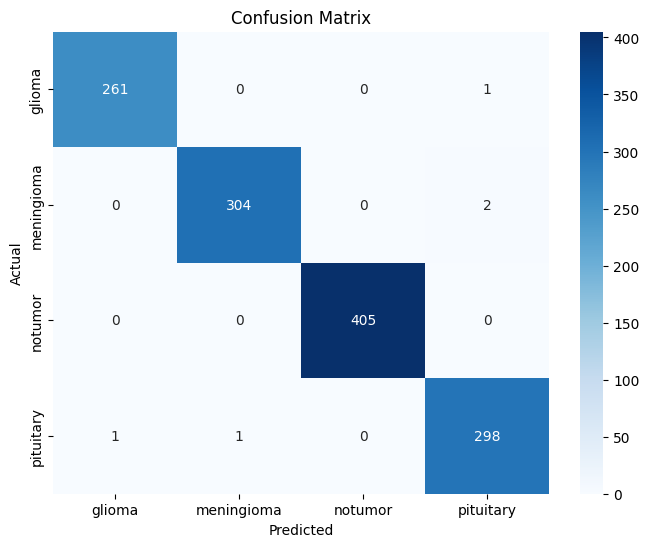

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

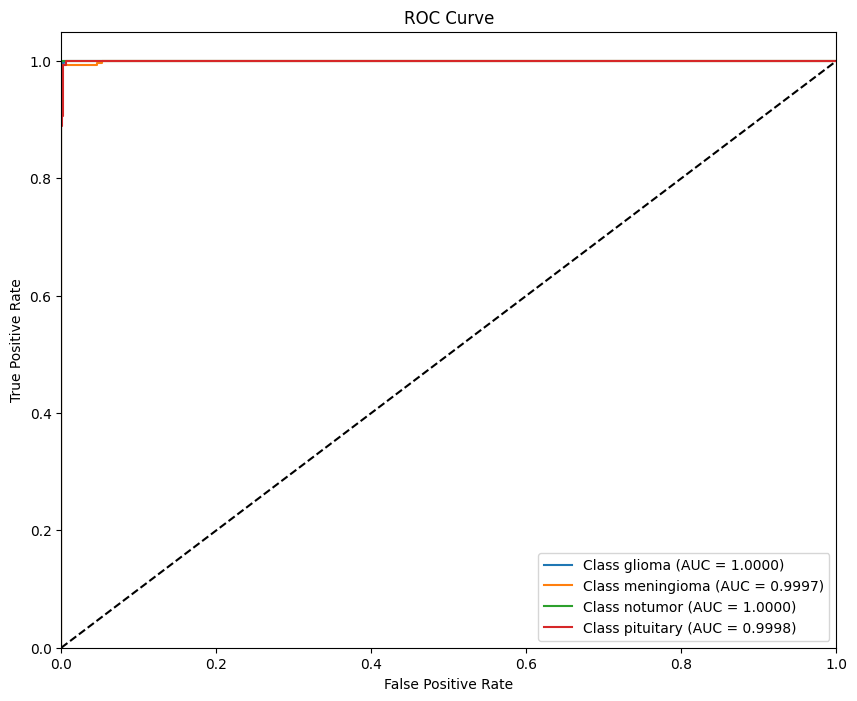

In [15]:
# ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {target_names[i]} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

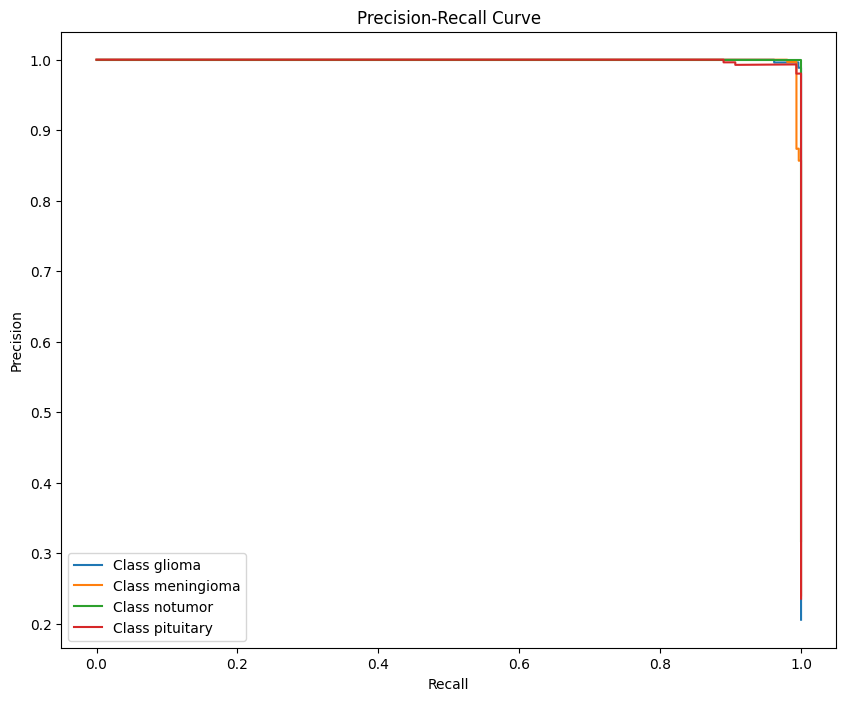

In [16]:
# Precision-Recall Curve for each class
plt.figure(figsize=(10, 8))
for i in range(4):
    precision, recall, _ = precision_recall_curve(y_true == i, y_pred[:, i])
    plt.plot(recall, precision, label=f'Class {target_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

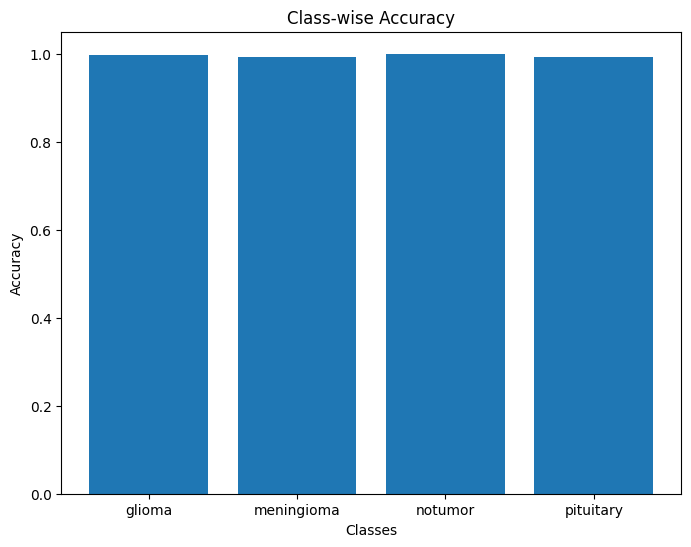

In [17]:
# Class-wise Accuracy Bar Plot
accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(8, 6))
plt.bar(target_names, accuracy_per_class)
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()

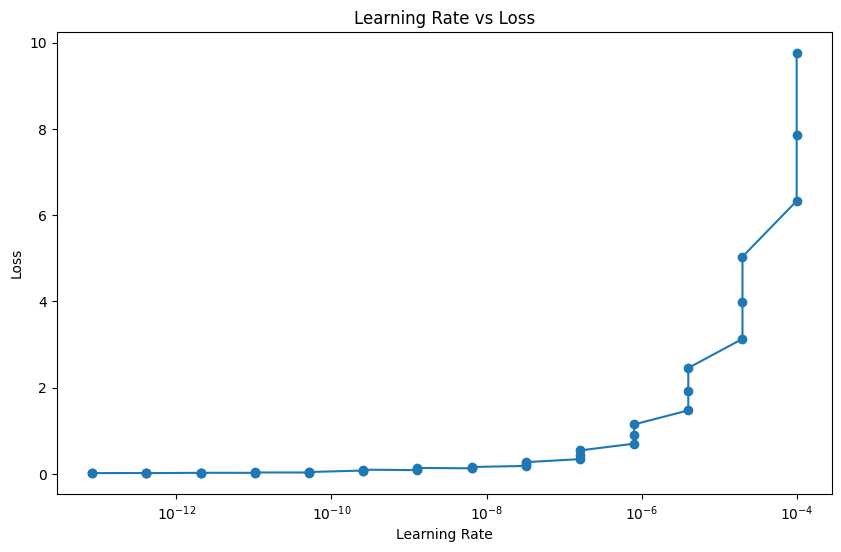

In [18]:
# Learning Rate vs Loss (Learning Rate Scheduler)
learning_rates = [0.0001 * (0.2 ** (i // 3)) for i in range(len(history.history['loss']))]
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, history.history['loss'], marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Learning Rate vs Loss')
plt.show()

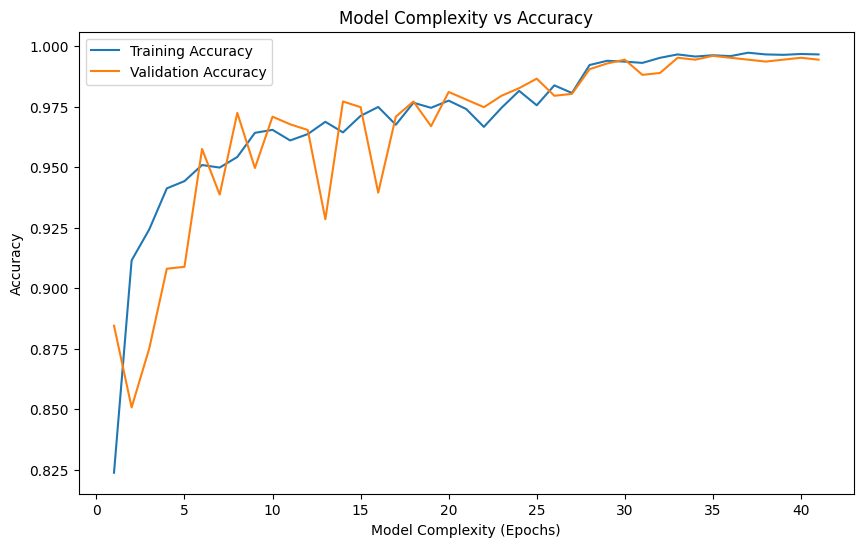

In [19]:
# Model Complexity vs Accuracy (Optional, depending on model complexity tracking)
plt.figure(figsize=(10, 6))
complexity = range(1, len(history.history['accuracy']) + 1)
plt.plot(complexity, history.history['accuracy'], label='Training Accuracy')
plt.plot(complexity, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Model Complexity (Epochs)')
plt.ylabel('Accuracy')
plt.title('Model Complexity vs Accuracy')
plt.legend()
plt.show()

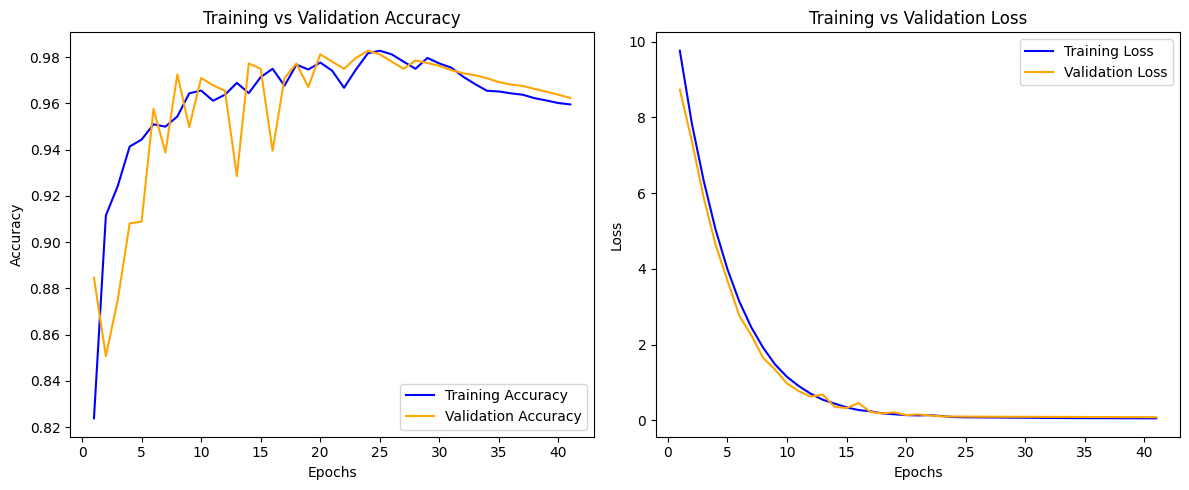

In [9]:
import matplotlib.pyplot as plt

# Example data (replace these with your actual data)
train_accuracy = [0.8238, 0.9115, 0.9243, 0.9413, 0.9443, 0.9509, 0.9499, 
                  0.9543, 0.9643, 0.9655, 0.9611, 0.9637, 0.9688, 0.9644, 
                  0.9713, 0.9749, 0.9676, 0.9767, 0.9746, 0.9776, 0.9741, 
                  0.9667, 0.9746, 0.9816, 0.98272, 0.98115, 0.9780, 0.9749, 
                  0.9796, 0.97722, 0.9754, 0.9715, 0.9683, 0.9654, 0.9651, 
                  0.9643, 0.9637, 0.9622, 0.9612, 0.9601, 0.9595]
val_accuracy = [0.88452, 0.8507, 0.8751, 0.90809, 0.90888, 0.95758, 0.9387, 
                0.97251, 0.9497, 0.9709, 0.9678, 0.9654, 0.9285, 0.97722, 
                0.9749, 0.9395, 0.9709, 0.9772, 0.9670, 0.98115, 0.9780, 
                0.9749, 0.9796, 0.98272, 0.98115, 0.9780, 0.9749, 0.9785, 
                0.9774, 0.9762, 0.9743, 0.9730, 0.9721, 0.9708, 0.9692, 
                0.9681, 0.9675, 0.9662, 0.9650, 0.9637, 0.9623]
train_loss = [9.7582, 7.8497, 6.3290, 5.0363, 3.9862, 3.1312, 2.4553, 
               1.9139, 1.4724, 1.1456, 0.9004, 0.7000, 0.5427, 0.4409, 
               0.3405, 0.2716, 0.2357, 0.1834, 0.1589, 0.1366, 0.1283, 
               0.1371, 0.1109, 0.0855, 0.0789, 0.0776, 0.0752, 0.0724, 
               0.0701, 0.0674, 0.0645, 0.0612, 0.0602, 0.0585, 0.0571, 
               0.0562, 0.0552, 0.0541, 0.0530, 0.0522, 0.0516]
val_loss = [8.7310, 7.3875, 5.8805, 4.6382, 3.6867, 2.7572, 2.2457, 
             1.6457, 1.3382, 0.9713, 0.7674, 0.6252, 0.6761, 0.3558, 
             0.3221, 0.4572, 0.2207, 0.1804, 0.2119, 0.1382, 0.1553, 
             0.1289, 0.1047, 0.1006, 0.0984, 0.0963, 0.0950, 0.0941, 
             0.0930, 0.0921, 0.0915, 0.0904, 0.0899, 0.0886, 0.0873, 
             0.0865, 0.0854, 0.0843, 0.0831, 0.0825, 0.0810]

epochs = range(1, len(train_accuracy) + 1)  # Number of epochs

# Create a figure with subplots
plt.figure(figsize=(12, 5))

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy', linestyle='-', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', linestyle='-', color='orange')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', linestyle='-', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', linestyle='-', color='orange')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
